In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import io
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import RegularGridInterpolator

plt.style.use('dark_background')

# from vis import *

254.97 325.05


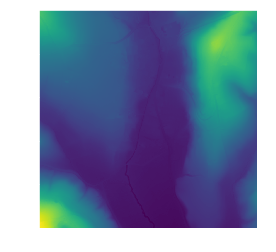

In [2]:
dem = io.imread("/home/klemen/_repo_RVT/RVT_py/test_data/TM1_564_146.tif")

print(dem.min(),dem.max())
plt.imshow(dem)
plt.show()

In [27]:
def slope_aspect(dem, resolution_x, resolution_y, ve_factor=1, output_units="radian"):
    """
    Procedure can return terrain slope and aspect in radian units (default) or in alternative units (if specified).
    Slope is defined as 0 for Hz plane and pi/2 for vertical plane.
    Aspect iz defined as geographic azimuth: clockwise increasing, 0 or 2pi for the North direction.
    Currently applied finite difference method.

    Parameters
    ----------
    dem : input dem 2D numpy array
    resolution_x : dem resolution in X direction
    resolution_y : DEM resolution in Y direction
    ve_factor : vertical exaggeration factor (must be greater than 0)
    output_units : percent, degree, radians

    Returns
    -------
    {"slope": slope_out, "aspect": aspect_out} : dictionaries with 2D numpy arrays
    """

    if ve_factor <= 0:
        raise Exception("rvt.vis.slope_aspect: ve_factor must be a positive number!")

    if resolution_x < 0 or resolution_y < 0:
        raise Exception("rvt.vis.slope_aspect: resolution must be a positive number!")

    dem = dem.astype(np.float32)
    if ve_factor != 1:
        dem = dem * ve_factor

    # add frame of 0 (additional row up bottom and column left right)
    dem = np.pad(dem, pad_width=1, mode="constant", constant_values=0)

    # derivatives in X and Y direction
    dzdx = ((np.roll(dem, 1, axis=1) - np.roll(dem, -1, axis=1)) / 2) / resolution_x
    dzdy = ((np.roll(dem, -1, axis=0) - np.roll(dem, 1, axis=0)) / 2) / resolution_y
    print(np.min(dzdx ** 2 + dzdy ** 2), np.max(dzdx ** 2 + dzdy ** 2))
    tan_slope = np.sqrt(dzdx ** 2 + dzdy ** 2)

    # Compute slope
    if output_units == "percent":
        slope_out = tan_slope * 100
    elif output_units == "degree":
        slope_out = np.rad2deg(np.arctan(tan_slope))
    elif output_units == "radian":
        slope_out = np.arctan(tan_slope)
    else:
        raise Exception("rvt.vis.calculate_slope: Wrong function input 'output_units'!")

    # compute Aspect
    # aspect identifies the down slope direction of the maximum rate of change in value from each cell to its neighbors:
    #     0
    # 270    90
    #    180
    dzdy[dzdy == 0] = 10e-9  # important for numeric stability - where dzdy is zero, make tangens to really high value

    aspect_out = np.arctan2(dzdx, dzdy)  # atan2 took care of the quadrants
    if output_units == "degree":
        aspect_out = np.rad2deg(aspect_out)

    # remove the frame (padding)
    slope_out = slope_out[1:-1, 1:-1]
    aspect_out = aspect_out[1:-1, 1:-1]

    # edges to -1
    slope_out[:, 0] = -1
    slope_out[0, :] = -1
    slope_out[:, -1] = -1
    slope_out[-1, :] = -1
    aspect_out[:, 0] = -1
    aspect_out[0, :] = -1
    aspect_out[:, -1] = -1
    aspect_out[-1, :] = -1

    return {"slope": slope_out, "aspect": aspect_out}

In [4]:
max_radius = 100
pyramid_scale = 3
max_pyramid_radius = 10
pyramid_levels = 10
pyramid = {}
pyramid[0] = np.arange(max_pyramid_radius)+1
for level in np.arange(pyramid_levels)+1:
    pyramid[level] = (np.arange(7)+4) * pyramid_scale**level
pyramid

{0: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 1: array([12, 15, 18, 21, 24, 27, 30]),
 2: array([36, 45, 54, 63, 72, 81, 90]),
 3: array([108, 135, 162, 189, 216, 243, 270]),
 4: array([324, 405, 486, 567, 648, 729, 810]),
 5: array([ 972, 1215, 1458, 1701, 1944, 2187, 2430]),
 6: array([2916, 3645, 4374, 5103, 5832, 6561, 7290]),
 7: array([ 8748, 10935, 13122, 15309, 17496, 19683, 21870]),
 8: array([26244, 32805, 39366, 45927, 52488, 59049, 65610]),
 9: array([ 78732,  98415, 118098, 137781, 157464, 177147, 196830]),
 10: array([236196, 295245, 354294, 413343, 472392, 531441, 590490])}

In [5]:
def horizon_shift_vector(num_directions=16, 
                         radius_pixels=10, 
                         min_radius=1,
                         ):
    
    """
    Calculates Sky-View determination movements.

    Parameters
    ----------
    num_directions : number of directions as input
    radius_pixels : radius to consider in pixels (not in meters)
    min_radius : radius to start searching for horizon in pixels (not in meters)


    Returns
    -------
    shift : dict with keys corresponding to the directions of search azimuths rounded to 1 decimal number
            - for each key, a subdict contains a key "shift":
                values for this key is a list of tuples prepared for np.roll - shift along lines and columns
            - the second key is "distance":
                values for this key is a list of search radius used for the computation of the elevation angle 
    """
    
    # Initialize the output dict
    shift = {}

    # Generate angles and corresponding normal shifts in X (columns)
    # and Y (lines) direction
    angles = (2 * np.pi / num_directions) * np.arange(num_directions) 
    x = np.cos(angles)
    y = np.sin(angles)
    angles = np.round(np.degrees(angles), decimals=1)
    
    # Generate a range of radius values in pixels.
    # Make it finer for the selcted scaling.
    # By adding the last constant we make sure that we do not start with
    # point (0,0).
    scale = 3.
    radii = np.arange((radius_pixels-min_radius)*scale+1) / scale + min_radius

    # For each direction compute all possible horizont point position
    # and round them to integers
    for i in range(num_directions):
        x_int = np.round(x[i] * radii, decimals=0)
        y_int = np.round(y[i] * radii, decimals=0)
        # consider only the minimal number of points
        # use the trick with set and complex nuber as the input
        coord_complex = set(x_int + 1j * y_int)
        # to sort proportional with increasing radius, 
        # set has to be converted to numpy array
        shift_pairs = np.array([(k.real, k.imag) for k in coord_complex]).astype(int)
        distance = np.sqrt(np.sum(shift_pairs**2, axis=1))
        sort_index = np.argsort(distance)
        # write for each direction shifts and corresponding distances
        shift[angles[i]] = {
            "shift": [(k[0],k[1]) for k in shift_pairs[sort_index]],
            "distance": distance[sort_index],
            }

    return shift

In [6]:
def horizon_generate_coarse_dem(dem_fine,
                                pyramid_scale,
                                conv_from,
                                conv_to,
                                max_radius,
                                ):

    # first reduce the size for the edge required for horizon search 
    dem_fine = dem_fine[max_radius:-max_radius, max_radius:-max_radius]
    
    # get and adjust the array sizes
    in_shape = dem_fine.shape
    n_col_fine = in_shape[1]
    n_lin_fine = in_shape[0]
    n_lin_coarse = int(np.floor(n_lin_fine / pyramid_scale)) + 1
    n_col_coarse = int(np.floor(n_col_fine / pyramid_scale)) + 1
    # The corner points must fit in the new grid.
    # This is always the case with the left most column or the upper line.
    # But you have to adjust ne number of columns to the right and number of lines below.
    # The final number of columns/lines has to fullfil:
    #     n_coarse = pyramid_scale * n_fine + 1
    # columns
    mod_col = n_col_fine % pyramid_scale
    pad_col = 0
    if mod_col!=1:
        pad_col = np.abs(1 - mod_col)
    # lines
    mod_lin = n_lin_fine % pyramid_scale
    pad_lin = 0
    if mod_lin!=1:
        pad_lin = np.abs(1 - mod_lin)
    # Here we extend it to right and below, so padding with edge is OK
    # Edge-mode otherwise creates artefacts on left and above.
    dem_fine = np.pad(dem_fine, ((0, pad_lin), (0, pad_col)), mode="edge")
    
    # Once you have data in the shape appropriate for resizing,
    # pad the data to support np.move.
    dem_fine = np.pad(dem_fine, ((-conv_from, conv_to), (-conv_from, conv_to)), mode="symmetric")
    
    # Convolution
    dem_convolve = np.zeros(dem_fine.shape)
    for i in np.arange(pyramid_scale)+conv_from:
        for j in np.arange(pyramid_scale)+conv_from:
            dem_convolve = dem_convolve + np.roll(dem_fine, (i,j), axis=(0,1))
    # 1) divide by pyramid_scale**2 to provide mean value within the convolution window
    # 2) additional divide by pyramid_scale to account for the chage of resolution
    # (important for the angle computation later on)
    dem_convolve = dem_convolve / pyramid_scale**3
    
    # Consider only the selceted convoluted points according to the scale change.
    # As we select slice's end point make sure to consider at least 1 point more 
    # to the right / below to really include it (Python way of considering end index).
    dem_coarse = dem_convolve[-conv_from:(n_lin_coarse*pyramid_scale+1):pyramid_scale, -conv_from:(n_col_coarse*pyramid_scale+1):pyramid_scale]
    
    # Final padding to enable searching the horizon over the edge:
    # use constant-mode set to the minimal height, so it doesn't 
    # affect the horizon estimation.
    dem_coarse = np.pad(dem_coarse, ((max_radius, max_radius), (max_radius, max_radius)), mode="constant", constant_values=dem_coarse.min())

    return dem_coarse

(521, 521)


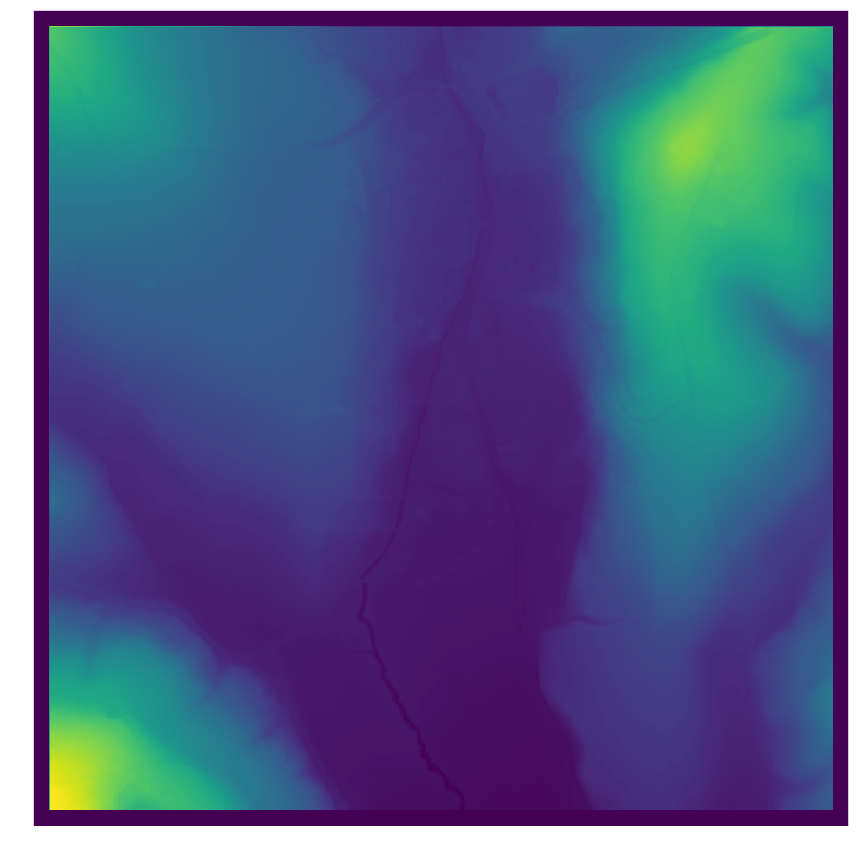

In [7]:
pyramid_scale = 2
max_radius = 10

dem_fine = np.pad(dem, max_radius, mode="edge")

conv_to = int(np.floor(pyramid_scale/2.))
if (pyramid_scale%2)==0:
    conv_from = 1 - conv_to
else:
    conv_from = -conv_to
dem_c = horizon_generate_coarse_dem(dem_fine, pyramid_scale, conv_from, conv_to, max_radius)
plt.figure(figsize=(15,15))
plt.imshow(dem_c)
print(dem_c.shape)

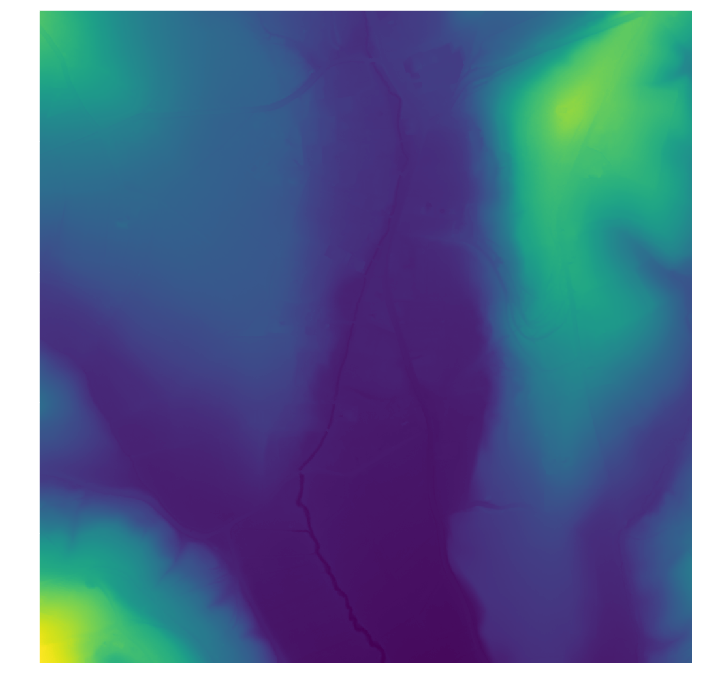

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(dem)

In [9]:
def horizon_generate_pyramids(dem,
                              num_directions=4,
                              max_fine_radius=100,
                              max_pyramid_radius=10,
                              pyramid_scale=5,
                              ):

    # In the levels higher than 1, determin the minimal search distance 
    # and number of search distances.
    # If you have for instance 
    #     pyramid_scale = 3
    #     max_pyramid_radius = 10
    #     num_directions = 8
    # then you have original distances in level 0:
    # 1, 2, 3, ... 9, 10
    # In level 1, your resolution is 3-times coarser.
    # The first pixel that takes that this new resolution,
    # has in original distance value 12 (in coarse resolution 4):
    # 12->4, 15->5, 18->6 ... 27->9, 30->10
    # So you start in the level 1 with tmin_pyramid_radius=4
    # and you search from 4 to 10 distances (n_pyramid_radius=7)
    min_pyramid_radius = int(np.floor(max_pyramid_radius / pyramid_scale)) + 1
    n_pyramid_radius = max_pyramid_radius - min_pyramid_radius + 1

    # get the convolution window indices
    conv_to = int(np.floor(pyramid_scale/2.))
    if (pyramid_scale%2)==0:
        conv_from = 1 - conv_to
    else:
        conv_from = -conv_to

    # initializations
    pyramid_levels = 0
    work = True
    pyramid = {}

    # Determine the number of levels and
    # the last radius to be used in the highest level.
    while work==True:
        _ = max_fine_radius / pyramid_scale**pyramid_levels
        if _ > max_pyramid_radius:
            pyramid_levels = pyramid_levels + 1
        else:
            work = False
            last_radius = np.round(max_fine_radius / pyramid_scale**pyramid_levels, decimals=0)


    # fFll out the pyramid dict with the metadata required for horizont searching.
    for level in np.arange(pyramid_levels+1):
            # the level 0 contains the other min_radius as the rest of levels 
            if level==0:
                min_radius = 1
                dem_fine = np.copy(np.pad(dem, max_pyramid_radius, mode="constant", constant_values=dem.min()))
            else:
                min_radius = min_pyramid_radius
                dem_fine = np.copy(dem_coarse)
            # the last level contains the other radius_pixels as the rest of levels
            if level == pyramid_levels:
                max_radius = last_radius
            else:
                max_radius = max_pyramid_radius
            # determine the dict of shifts
            shift = horizon_shift_vector(num_directions, max_radius, min_radius)
            dem_coarse = horizon_generate_coarse_dem(dem_fine, pyramid_scale, conv_from, conv_to, max_pyramid_radius)
            i_lin = np.arange(dem_fine.shape[0])
            i_col = np.arange(dem_fine.shape[1])
#             lin_coarse = np.arange(dem_coarse.shape[0]) * pyramid_scale - conv_from
#             col_coarse = np.arange(dem_coarse.shape[1]) * pyramid_scale - conv_from
            pyramid[level] = {
                "num_directions": num_directions,
                "radius_pixels": max_radius,
                "min_radius": min_radius,
                "shift": shift,
                "dem": dem_fine,
#                 "pad_lin": pad_lin,
#                 "pad_col": pad_col,
                "i_lin": i_lin,
                "i_col": i_col,
#                 "lin_coarse": lin_coarse,
#                 "col_coarse": col_coarse,
                }
#             plt.imshow(dem_fine)
#             plt.show()

    return pyramid

In [10]:
pyramid = horizon_generate_pyramids(dem)
# pyramid

In [11]:
# print(np.max([i for i in pyramid]))
# print(pyramid[3]["dem"].shape)

In [12]:
# a=horizon_shift_vector(8, 4, 4)
# for i in a.keys():
#     print(f"angle {i}")
#     for j in a[i]:
#         print(f"{j}: {a[i][j]}")

In [28]:
tic=time.time()
# def sky_view_factor_com_new(
num_directions=32
max_fine_radius=200
pyramid_scale=3
max_pyramid_radius=10
height=dem
compute_overcast=False
compute_uniform=True
resolution_x=1
resolution_y=1

#     """
#     """
# generate slope and aspect
_ = slope_aspect(np.pad(height, max_pyramid_radius, mode="symmetric"), resolution_x, resolution_y)
slope = _["slope"]
aspect = _["aspect"]

# build DEM pyramids
pyramid = horizon_generate_pyramids(height,
                                    num_directions=num_directions,
                                    max_fine_radius=max_fine_radius,
                                    max_pyramid_radius=max_pyramid_radius,
                                    pyramid_scale=pyramid_scale,)
n_levels = np.max([i for i in pyramid])
# get the convolution window indices
conv_to = int(np.floor(pyramid_scale/2.))
if (pyramid_scale%2)==0:
    conv_from = 1 - conv_to
else:
    conv_from = -conv_to
# angular halve-resolution for integration limits
da = np.pi / num_directions

# init the output for overcast SI
if compute_overcast:
    overcast_out = np.zeros(height.shape, dtype=np.float32)
else:
    overcast_out = None
# init the intermediate results for uniform SI
if compute_uniform:
    uniform_a = np.zeros((height.shape[0]+2*max_pyramid_radius, height.shape[1]+2*max_pyramid_radius), dtype=np.float32)
    uniform_b = np.copy(uniform_a)
else:
    uniform_out = None 

# search for horizon in each direction...
for i_dir, direction in enumerate(pyramid[0]["shift"]):
    # reset maximum at each iteration (direction)
    max_slope = np.zeros(pyramid[n_levels]["dem"].shape, dtype=np.float32) - 1000

    for i_level in reversed(range(n_levels+1)):
        height = pyramid[i_level]["dem"]
        move = pyramid[i_level]["shift"]

        # ... and to the search radius
        for i_rad, radius in enumerate(move[direction]["distance"]):
            # get shift index from move dictionary
            shift_indx = move[direction]["shift"][i_rad]
            # estimate the slope
            _ = (np.roll(height, shift_indx, axis=(0,1)) - height) / radius
            # compare to the previus max slope and keep the larges
            max_slope = np.maximum(max_slope, _)

        # resample the max_slope to a lower pyramid level
        if i_level > 0:
            lin_fine = pyramid[i_level-1]["i_lin"] + (conv_from + max_pyramid_radius*pyramid_scale - max_pyramid_radius)
            col_fine = pyramid[i_level-1]["i_col"] + (conv_from + max_pyramid_radius*pyramid_scale - max_pyramid_radius)
            lin_coarse = pyramid[i_level]["i_lin"] * pyramid_scale
            col_coarse = pyramid[i_level]["i_col"] * pyramid_scale
            interp_spline = RectBivariateSpline(lin_coarse, col_coarse, max_slope)
            max_slope = interp_spline(lin_fine, col_fine)

    # convert to angle in radians and compute directional output
    _ = np.arctan(max_slope)
    uniform_a = uniform_a + (np.cos(max_slope))**2
    uniform_b = uniform_b + (np.sin((direction-da) - aspect) - np.sin((direction+da) - aspect)) * (np.pi/4. - max_slope/2. - np.sin(2.*max_slope)/4.)

if compute_uniform:
    uniform_out = da * np.cos(slope) * uniform_a + np.sin(slope) * uniform_b
    uniform_out = uniform_out[max_pyramid_radius:-max_pyramid_radius, max_pyramid_radius:-max_pyramid_radius] / np.pi
toc = time.time()
print(toc-tic)
#     if compute_svf:
#         svf_out = svf_out + (1 - np.sin(np.maximum(_,0)))
#     if compute_asvf:
#         asvf_out = asvf_out + (1 - np.sin(np.maximum(_,0))) * weight[i_dir]
#     if compute_opns:
#         opns_out = opns_out + _

# # cut to original extent and 
# # average the directional output over all directions
# if compute_svf:
#     svf_out = svf_out[radius_max:-radius_max, radius_max:-radius_max] / num_directions
# if compute_asvf:
#     asvf_out = asvf_out[radius_max:-radius_max, radius_max:-radius_max]  / np.sum(weight)
# if compute_opns:
#     opns_out = np.rad2deg(0.5 * np.pi - (opns_out[radius_max:-radius_max, radius_max:-radius_max] / num_directions))

# # return results within dict
# dict_svf_asvf_opns = {"svf": svf_out, "asvf": asvf_out, "opns": opns_out}
# dict_svf_asvf_opns = {k: v for k, v in dict_svf_asvf_opns.items() if v is not None}  # filter out none



0.0 52504.2


/home/klemen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt


5.050163269042969


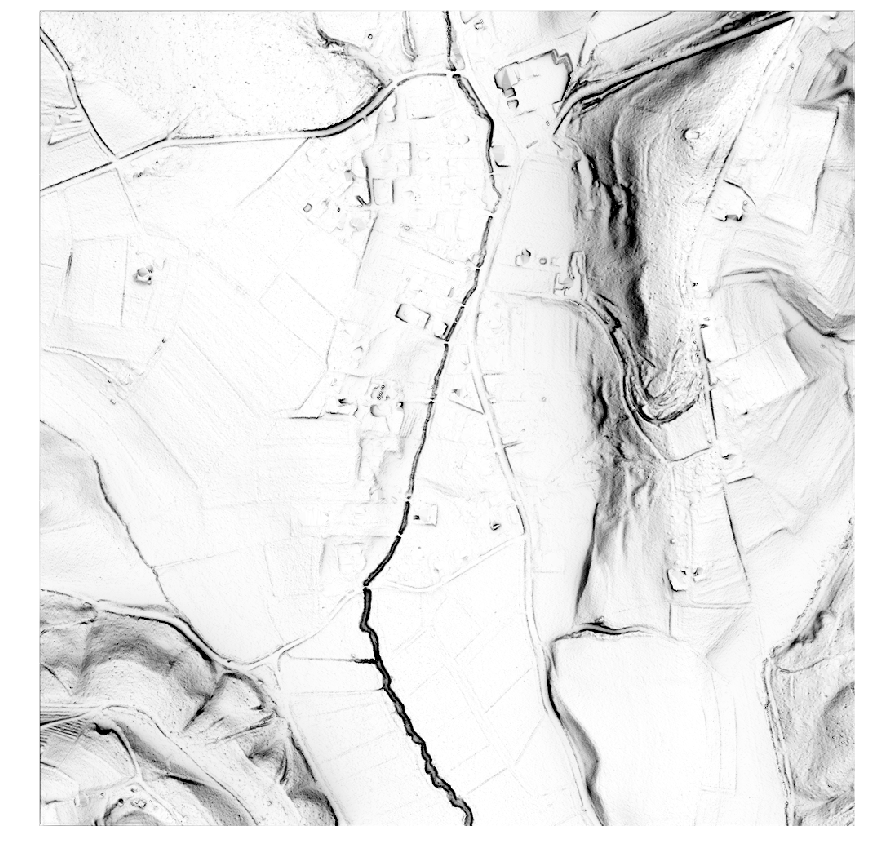

1.002311006317911

In [24]:
plt.figure(figsize=(15,15))
plt.imshow(uniform_out, cmap="gray", vmin=0.7, vmax=1.)
plt.show()
uniform_out.max()

In [25]:
tic = time.time()
# new = sky_view_factor_com_new(dem, 
#                             radius_max=10, 
#                             radius_min=1, 
#                             num_directions=32,
#                             compute_svf=True,
#                             compute_asvf=True,
#                             compute_opns=True)

toc = time.time()
print(toc-tic)

1.9550323486328125e-05
